# Granularity in mixed-integer nonlinear optimization

## Summary of the document

This document is complementary to the paper "Granularity in mixed-integer nonlinear optimization". The intention is to make the numerical results transparent. The generated results for the IPCP, the feasibility pump as well as for B-Hyb are stored as pandas data-frames and are concatenated herein. 

The latex-tables of the article are produced by using the command print(dataframe.to_latex(float_format = '%.2f'))

In [55]:
import pandas as pd
pd.options.display.float_format = '${:,.2f}'.format
import numpy as np
import pickle
from ast import literal_eval

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def store_FRA_results_for_Bonmin(pseudo_granular_results):
    np.save('vals_SOR',np.array(pseudo_granular_results['obj']))
    testbed = list(pseudo_granular_results.index)
    with open(r'../testbed/SOR_succ.txt', 'w') as f:
        for item in testbed:
            f.write("%s\n" % item)
def load_successful_results(name):
    results = load_obj(name)
    succ_results = results[results['obj'] != float('inf')]
    print(len(succ_results)," Problems are pseudo granular")
    return succ_results

def load_problems_with_computable_Lipschitz_constant(name):
    results = load_obj(name)
    L_results = results.loc[results['time L']<=1800]
    print("We can compute Lipschitz constants for", len(L_results)," Problems")
    return L_results

def load_problems_with_time_limit_Lipschitz(name):
    results = load_obj(name)
    L_results = results.loc[results['time L']>1800]
    print("We can't compute Lipschitz constants for", len(L_results)," Problems")
    return L_results
    
def find_simple_problems(result_frame):
    constr_quadrouple = result_frame['constrs'].to_list()
    simple_problems = []
    for idx, quadrouple in enumerate(constr_quadrouple):
        if quadrouple[-6:-1] == ' 0, 0':
            simple_problems.append(result_frame.index[idx])
    return simple_problems

def list_of_instances_from_A_not_contained_in_B(resA,resB):
    res_set = set(resA.index)
    res_set.difference_update(list(resB.index))
    res_list = list(res_set)
    res_list.sort()
    return res_list

def filter_instances_nonlinear_in_y(result):
    result_nonlinear = result[result['constrs'].apply(lambda x: int(x[-2]))>0]
    return result_nonlinear

def filter_out_only_epi_problems(result):
    result_nonepi = result[result['constrs']!='(1, 1, 1, 1)']
    return result_nonepi

def update_objective_value_epi_problems(result):
    epi_subset = result['constr_value'] != float('-inf') 
    result.loc[epi_subset,'obj'] = np.array(result[epi_subset]['obj']+result[epi_subset]['constr_value'])
    result = result.drop('constr_value',axis=1)
    return result

def print_numbers_of_different_problemclasses(results):
    class0 = 0
    class1 = 0
    class2 = 0
    for name in results.index.to_list():
        constr_tuple = literal_eval(results.loc[name].constrs)
        if constr_tuple[2] == 0:
            class0 +=1
        elif constr_tuple[3] == 0:
            class1 +=1
        else:
            class2 += 1
    print("only polyhedral integer constraints: ",class0,
          "\ninteger variables occur in nonlinear constraints but only in a linear fashion: ",class1,
          "\nreal nonlinear integer constraints:",class2)
    
def print_numbers_of_purely_epi_problems(results):
    epi_problems = 0
    for name in results.index.to_list():
        constr_array = np.array(literal_eval(results.loc[name].constrs))
        if all(constr_array == 1):
            epi_problems +=1
    print("purely epi problems:",epi_problems)
    
def delete_irrelevant_information_Lipschitz_table(results):
    for name in results.index.to_list():
        constr_array = np.array(literal_eval(results.loc[name,'constrs']))
        var_array = np.array(literal_eval(results.loc[name,'vars']))
        results.loc[name,'constrs'] = constr_array[0] - 1
        results.loc[name,'vars'] = var_array[0]-1
        
def print_Lipschitz_information(res_main, res_comp):
    results_L_not_computable = load_problems_with_time_limit_Lipschitz(res_main)
    delete_irrelevant_information_Lipschitz_table(results_L_not_computable)
    print("For the following problems, we can not compute a Lipschitz constant")   
    print(results_L_not_computable[['vars','constrs']].to_latex(float_format = '%.2f'))
    
    results_L_computable = load_problems_with_computable_Lipschitz_constant(res_main)
    delete_irrelevant_information_Lipschitz_table(results_L_computable)
    print("For the following problems, we can compute a Lipschitz constant and the "
      "computation takes more than 5 seconds")      
    print(results_L_computable[results_L_computable['time L']>5]
      [['vars','constrs','time L']].to_latex(float_format = '%.2f'))
    
    print('In the following we compare the results to delta = 0.5 and list problems that only have a computable'
         ' Lipschitz constant in the latter case')
    results_L_computable_05 = load_problems_with_computable_Lipschitz_constant(res_comp)
    Lipschitz_possible_only_05 = list_of_instances_from_A_not_contained_in_B(results_L_computable_05,results_L_computable)
    delete_irrelevant_information_Lipschitz_table(results_L_computable_05)
    print(results_L_computable_05.loc[Lipschitz_possible_only_05][['vars','constrs','time L']].to_latex(float_format = "%.2f"))


    
def print_all_tables_for_paper(res_main, res_comp):    
    print_Lipschitz_information(res_main, res_comp)
    #print_feasible_point_results_for_paper(res_main)
        
def print_feasible_point_results_for_paper(filename):
    results_pseudo_granular = load_successful_results(filename)
    results_nonepi = filter_out_only_epi_problems(results_pseudo_granular)
    result_nonepi_post_processed = update_objective_value_epi_problems(results_nonepi)
    res_bonmin = load_obj('res_bonmin')
    infeasible_problems = ['genpooling_lee2','nous1', 'nous2', 'ringpack_20_1', 'ringpack_20_2', 'ringpack_30_1']
    res_bonmin['time_bonmin'].loc[infeasible_problems] = float('inf')
    res_bonmin['obj_bonmin'].loc[infeasible_problems] = float('-inf')
    overview = pd.concat([result_nonepi_post_processed,res_bonmin['time_bonmin']],axis=1)
    if any(res_bonmin['obj_bonmin'] - result_nonepi_post_processed['obj'] > 1E-4):
        print('Warning: Bonmin has worse objective value for some problems!')
    order = ['vars','constrs', 'obj','time L', 'time SOR', 'time_bonmin']
    modified_overview = overview[order]
    print(modified_overview.to_latex(float_format = '%.2f'))
    modified_overview['time_bonmin'].loc[infeasible_problems] = float('inf')
    no_SOR_better = sum(modified_overview['time L']+ modified_overview['time SOR']< modified_overview['time_bonmin'])
    no_SOR_worse = sum(modified_overview['time L']+ modified_overview['time SOR']> modified_overview['time_bonmin'])
    print("Sor valuable in", no_SOR_better, 
          "cases, Bonmin better in",no_SOR_worse, "cases")

# Analysis of results
We tested FRA-SOR for $\delta \in \{0.5,0.75,0.9999\}$, with $\delta$ being the enlargement parameter for the box constraints. We found that most problems were granular for $\delta = 0.9999$ (even though Lipschitz constants were bigger). However, interestingly, we found that the larger the value of $\delta$, the more difficult the computation of Lipschitz constants (i.e. the longer the solver needed to solve the auxiliary problem).

Next, we report our main results with $\delta = 0.9999$.

## Overview of numbers given in the paper

In [56]:
result_files = ['SOR_all_instances_0.5','SOR_all_instances_0.75','SOR_all_instances_0.9999']
for name in result_files:
    results_overall = load_obj(name)
    results_L_computable = load_problems_with_computable_Lipschitz_constant(name)
    results_pseudo_granular = load_successful_results(name)
    results_L_not_computable = load_problems_with_time_limit_Lipschitz(name)
print_numbers_of_different_problemclasses(results_overall)
print_numbers_of_purely_epi_problems(results_overall)    

We can compute Lipschitz constants for 197  Problems
42  Problems are pseudo granular
We can't compute Lipschitz constants for 13  Problems
We can compute Lipschitz constants for 184  Problems
41  Problems are pseudo granular
We can't compute Lipschitz constants for 26  Problems
We can compute Lipschitz constants for 183  Problems
52  Problems are pseudo granular
We can't compute Lipschitz constants for 27  Problems
only polyhedral integer constraints:  68 
integer variables occur in nonlinear constraints but only in a linear fashion:  10 
real nonlinear integer constraints: 132
purely epi problems: 24


## Tables used in the paper
The block below prints all relevant tables used in the paper. 

## Lipschitz computation

In [39]:
res_main = 'SOR_all_instances_0.9999'
res_comp = 'SOR_all_instances_0.5'
print_all_tables_for_paper(res_main, res_comp)

We can't compute Lipschitz constants for 27  Problems
For the following problems, we can not compute a Lipschitz constant
\begin{tabular}{lrr}
\toprule
{} &  vars &  constrs \\
\midrule
edgecross14-058   &   182 &     1456 \\
edgecross14-098   &   182 &     1456 \\
edgecross14-117   &   182 &     1456 \\
edgecross14-137   &   182 &     1456 \\
edgecross20-040   &   380 &     4560 \\
edgecross20-080   &   380 &     4560 \\
edgecross22-048   &   462 &     6160 \\
edgecross22-096   &   462 &     6160 \\
edgecross24-057   &   552 &     8096 \\
edgecross24-115   &   552 &     8096 \\
faclay20h         &   190 &     2280 \\
faclay25          &   300 &     4600 \\
faclay30          &   435 &     8120 \\
faclay30h         &   435 &     8120 \\
faclay33          &   528 &    10912 \\
faclay35          &   595 &    13090 \\
sporttournament30 &   435 &        0 \\
sporttournament32 &   496 &        0 \\
sporttournament34 &   561 &        0 \\
sporttournament36 &   630 &        0 \\
sporttournamen

## Computation of feasible points

In [43]:
res_comp_overall = load_obj('ComparisonSOR_succ')
columns1 = ['vars','constrs', 'obj','time L', 'time SOR', 'time_B-BB','time_B-Hyb','time_B-iFP']
print(res_comp_overall[columns1].to_latex(float_format = '%.2f'))
a = []
for comp in ['time_B-BB','time_B-Hyb','time_B-iFP']:
    print("SOR better than ", comp, "in",
          sum(res_comp_overall['time L']+res_comp_overall['time SOR'] < res_comp_overall[comp]), "cases")
    print("SOR worse than ", comp, "in",
          sum(res_comp_overall['time L']+res_comp_overall['time SOR'] > res_comp_overall[comp]), "cases")
    a.append(res_comp_overall['time L']+res_comp_overall['time SOR'] < res_comp_overall[comp])
print("SOR better than all other methods in ", sum(a[0] & a[1] & a[2]), "cases")    

\begin{tabular}{lllrrrrrr}
\toprule
{} &             vars &                constrs &         obj &  time L &  time SOR &  time\_B-BB &  time\_B-Hyb &  time\_B-iFP \\
\midrule
cvxnonsep\_normcon20r  &      (40, 10, 0) &       (21, 20, 10, 10) &      -14.65 &    1.37 &      0.05 &       0.09 &        0.20 &        0.14 \\
cvxnonsep\_normcon30r  &      (60, 15, 0) &       (31, 30, 15, 15) &      -14.80 &    1.73 &      0.02 &       0.14 &        0.08 &        0.06 \\
ex1223a               &        (7, 4, 4) &           (9, 4, 4, 0) &        6.07 &    0.00 &      0.05 &       0.03 &        0.09 &        0.08 \\
ex4                   &     (36, 25, 25) &        (30, 25, 25, 0) &       -6.70 &    0.00 &      0.03 &       0.08 &        0.81 &        0.83 \\
genpooling\_lee1       &       (49, 9, 9) &         (82, 20, 0, 0) &    -4309.83 &    0.00 &      0.70 &        inf &         inf &         inf \\
genpooling\_lee2       &       (53, 9, 9) &         (92, 30, 0, 0) &    -3849.24 &    0.00 &

## Plot cumulative distribution function

In [2]:
from matplotlib import pyplot as plt
import re
from matplotlib import rc
%matplotlib inline

In [25]:
res_comp_overall = load_obj('ComparisonSOR_succ')

In [26]:
time_SOR = np.array(res_comp_overall['time L']+ res_comp_overall['time SOR'])
time_FP = np.array(res_comp_overall['time_B-iFP'])
time_BB = np.array(res_comp_overall['time_B-BB'])
time_Hyb = np.array(res_comp_overall['time_B-Hyb'])
time_SOR.sort()
time_BB.sort()
time_FP.sort()
time_Hyb.sort()
time_max = 2000
time_FP[time_FP==np.inf]= time_max
time_BB[time_BB==np.inf] = time_max
time_Hyb[time_Hyb==np.inf] = time_max

Text(0, 0.5, 'Number of Instances')

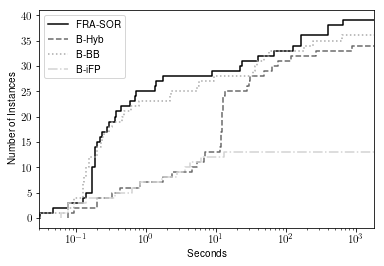

In [27]:
rc('text', usetex=True)
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('xtick', labelsize=11)
rc('ytick', labelsize=11)
colors = ['black','dimgray','darkgray','lightgray']
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.set_xlim(0.03,1800)
ax.step(np.concatenate([time_SOR, [time_max]]), np.arange(time_SOR.size+1), label='FRA-SOR', color = colors[0])
ax.step(np.concatenate([time_Hyb, [time_max]]), np.arange(time_Hyb.size+1), 
        label='B-Hyb', linestyle = '--', color = colors[1])
ax.step(np.concatenate([time_BB, [time_max]]), np.arange(time_BB.size+1), 
        label='B-BB', linestyle = ':', color = colors[2])
ax.step(np.concatenate([time_FP, [time_max]]), np.arange(time_FP.size+1), 
        label='B-iFP', linestyle = '-.', color = colors[3])
ax.legend()
ax.set_xlabel('Seconds')
ax.set_ylabel('Number of Instances')
#fig.savefig('CDF.eps', bbox_inches='tight')

## Comparison with $\delta = 0.75$

In [40]:
results_075 = load_obj('SOR_succ075')

In [57]:
com_obj = pd.concat([results_075['obj'],res_comp_overall['obj']],axis=1)
com_obj.columns = ['0.75','0.9999']
com_obj = com_obj.dropna()
com_obj

C:\Users\hg2412\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0.75,0.9999
cvxnonsep_normcon20r,$-15.61,$-14.65
cvxnonsep_normcon30r,$-15.44,$-14.80
ex1223a,$6.07,$6.07
ex4,$-6.37,$-6.70
genpooling_lee1,"$-3,714.30","$-4,309.83"
genpooling_lee2,"$-2,971.29","$-3,849.24"
genpooling_meyer10,"$6,017,292.88","$5,129,659.13"
genpooling_meyer15,"$6,823,781.41","$6,581,050.03"
ndcc12,$108.11,$108.11
ndcc14,$143.31,$143.31


In [58]:
print(sum(com_obj["0.75"]<com_obj["0.9999"]))
print(sum(com_obj["0.75"]>com_obj["0.9999"]))
print(sum(com_obj["0.75"]==com_obj["0.9999"]))

12
9
6


## Lipschitz computation
Here, we give a more detailed analysis of how much time the computation of Lipschitz constants take dependently on the problem-size. Let us start with problems where the Lipschitz constant is not computable

In [58]:
name = 'SOR_all_instances_0.9999'
results_L_computable = load_problems_with_computable_Lipschitz_constant(name)
results_L_not_computable = load_problems_with_time_limit_Lipschitz(name)
delete_irrelevant_information_Lipschitz_table(results_L_not_computable)
results_L_not_computable[['vars','constrs']]

We can compute Lipschitz constants for 183  Problems
We can't compute Lipschitz constants for 27  Problems


,vars,constrs
edgecross14-058,182,1456
edgecross14-098,182,1456
edgecross14-117,182,1456
edgecross14-137,182,1456
edgecross20-040,380,4560
edgecross20-080,380,4560
edgecross22-048,462,6160
edgecross22-096,462,6160
edgecross24-057,552,8096
edgecross24-115,552,8096


Below, we list the 10 interesting problems where the computation of all Lipschitz constants is possible and takes at least 5 seconds time

In [36]:
results_L_computable[results_L_computable['time L']>5][['vars','constrs','time L']]

,vars,constrs,time L
edgecross10-040,"(91, 90, 90)","(481, 1, 1, 1)",$26.10
edgecross10-050,"(91, 90, 90)","(481, 1, 1, 1)",$51.44
edgecross10-070,"(91, 90, 90)","(481, 1, 1, 1)","$1,095.28"
edgecross14-176,"(183, 182, 182)","(1457, 1, 1, 1)",$240.80
sporttournament18,"(154, 153, 153)","(1, 1, 1, 1)",$10.12
sporttournament20,"(191, 190, 190)","(1, 1, 1, 1)",$16.81
sporttournament22,"(232, 231, 231)","(1, 1, 1, 1)",$22.10
sporttournament24,"(277, 276, 276)","(1, 1, 1, 1)",$188.42
sporttournament26,"(326, 325, 325)","(1, 1, 1, 1)",$228.91
sporttournament28,"(379, 378, 378)","(1, 1, 1, 1)",$470.62


Interestingly, as mentioned above, for enlargement parameter $\delta = 0.5$, we can compute Lipschitz constants even for larger problems. Below, we list all 14 problems where we get a Lipschitz constant for $\delta = 0.5$, but not for $\delta = 0.9999$

In [37]:
results_L_computable_05 = load_problems_with_computable_Lipschitz_constant('SOR_all_instances_0.5')
Lipschitz_possible_only_05 = list_of_instances_from_A_not_contained_in_B(results_L_computable_05,results_L_computable)
delete_irrelevant_information_Lipschitz_table(results_L_computable_05)
results_L_computable_05.loc[Lipschitz_possible_only_05][['vars','constrs','time L']]

We can compute Lipschitz constants for 197  Problems


,vars,constrs,time L
edgecross14-058,182,1456,$520.11
edgecross20-040,380,4560,$1.98
edgecross22-048,462,6160,$3.36
edgecross24-057,552,8096,$14.25
faclay20h,190,2280,$148.15
sporttournament30,435,0,$10.40
sporttournament32,496,0,$14.11
sporttournament34,561,0,$87.51
sporttournament36,630,0,$154.54
sporttournament38,703,0,$283.66
